# DISCOVER FASHION MNIST DATA SET BY APPYLING ENSEMBLE LEARNING AND PCA

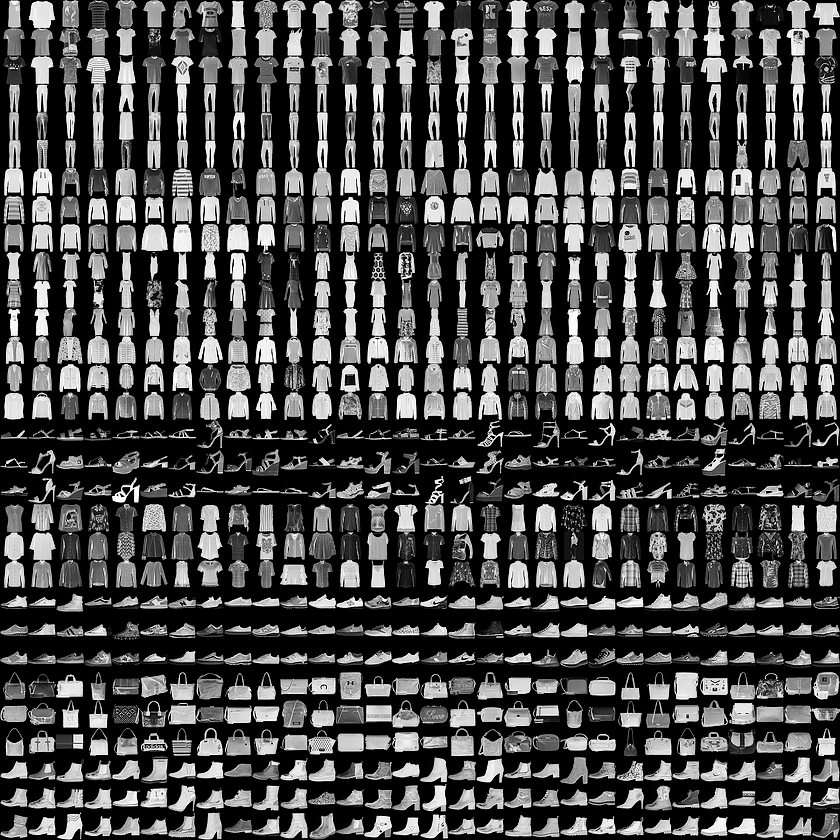

In [12]:
from IPython.display import Image
Image(filename='wjr4OUT.png')

*We will handle the following sections :*
- **0) Introduction**
- **1) Reading train set**
- **2) Visualize data :** *take a look how these images (before and after using PCA) look like*
- **3) Prepare data** : *prepare by looking at correlations with label , or using PCA*
- **4) Selecting top 2 model :** *we will walk through some popular classifiers and then some ensemble learning methods*
- **5) Optimize model :** *try to fine tune above top 2*
- **6) Deep into dimension reduction :** *we will investigate more how number of dimension affects F1_score and recall_score*
- **7) Train on whole data set and making predictions :** *investigate on 3 kinds of data set*
- **8) Conclusions**

# 0) Introduction

In [5]:
def create_categorie_data_frame() :
    label_lyst = [i for i in range(10)]
    categorie_lyst = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankel Boot']
    label_frame = {'label':label_lyst,'categorie':categorie_lyst}
    return pd.DataFrame(label_frame).T
create_categorie_data_frame()

,0,1,2,3,4,5,6,7,8,9
label,0,1,2,3,4,5,6,7,8,9
categorie,T-shirt/Top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankel Boot


# 1) Reading train set

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [25]:
train_set = pd.read_csv('fashion-mnist_train.csv')

In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


*See. We have 60K data points , 784 features , 1 label column*

In [3]:
train_set.isnull().sum().sum()

0

*No missing values at all*

*For looking around several models to feel how it works, we just pick a 5000 - size sample*

In [5]:
data = train_set.sample(5000)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 10478 to 35045
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 30.0 MB


# 2) Visualize data

*Now let's visualize 10 data points (called **example** below) to see how images look like. Our first goal is creating a data frame having 10 rows corresponding 10 categories. To make sure , let's check how it is for the very first label*

In [70]:
example = data[data.iloc[:,0]==0].sample(1)

In [71]:
example.iloc[0,0]

0

In [86]:
example.drop(example.columns[0],axis=1)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
29481,0,0,0,0,0,0,0,0,1,9,...,45,55,51,0,0,0,0,0,0,0


*Now we define a function to extend all 10 rows (contained in something called **example_X**). We pass in a set and desire to get a new data frame*

In [7]:
def create_frame_to_visualize(set_) :
    example = set_[set_.iloc[:,0]==0].sample(1)
    example_label = example.iloc[0,0]
    example_X = example.drop(example.columns[0],axis=1) # initialize with the very first categorie
    for i in range(1,10) : # and then concatenate 9 others
        example = set_[set_.iloc[:,0]==i].sample(1)
        example_feature = example.drop(example.columns[0],axis=1)
        example_X = pd.concat([example_X,example_feature])
    return example_X

*Next we define a function to plot. Our function passes in data , height and weight with the same default 28*

In [19]:
def plot_images(data, height=28, width=28):
    fig, axes = plt.subplots(2,5, figsize=(10, 4),subplot_kw=dict(xticks=[], yticks=[]))
    for i, ax in enumerate(axes.flat):
        ax.set_title(categorie_lyst[i],fontsize=20,c='r')
        ax.imshow(data.iloc[i,:].values.reshape(height, width),cmap='gray')

*Now look !*

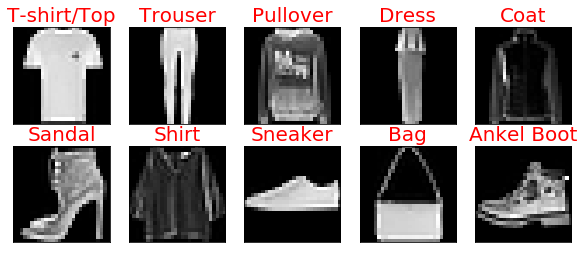

In [20]:
plot_images(create_frame_to_visualize(data))

*Images look so blurry. This is because they just have 28 x 28 pixels*

*In this notebook , we gonna try to do some features engineering like feature selection and using PCA. Now jump into PCA and play with it !*

## PCA

*To start working with PCA , we need to know how many components are suitable. We need to plot **cumulative explained variance***

In [21]:
from sklearn.decomposition import PCA
def cumulative_explained_variance_plot(data):
    matrix_ = data.values
    pca = PCA()
    pca.fit(matrix_[:,1:])
    
    sns.set_style('whitegrid')

    plt.figure(figsize=(12,7))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('Cumulative Explained Variance',fontsize=30)
    plt.xlabel('number of components',fontsize = 20)
    plt.ylabel('cumulative explained variance',fontsize=20)

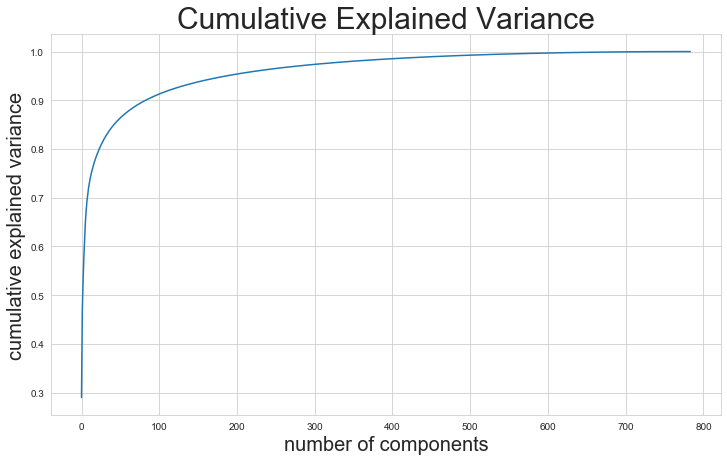

In [22]:
cumulative_explained_variance_plot(train_set)

*Look ! If we choose **n = 500** we still retain almost 100% origin data. Let's see how good result is in next section*

*Now time to create new data by using PCA. Our function here passes in data , number of compenents. It returns new data frame possessing signicicantly reduced dimension. Chalenge here is we do transform all columns with exception label column*

In [23]:
def create_new_data_by_pca(data,n) :
    pca = PCA(n_components=n)
    matrix_ = data.values # including label column
    projected_matrix_ = pca.fit_transform(matrix_[:,1:]) # without label column
    new_matrix = np.hstack((matrix_[:,0].reshape(data.shape[0],1),projected_matrix_))
    lyst_col = [i for i in range(n+1)] # define column name
    lyst_idx = [i for i in range(data.shape[0])] # define index
    new_data = pd.DataFrame(data=new_matrix,index=lyst_idx,columns=lyst_col) # recreate data frame
    new_data.rename({0:'label'},axis=1,inplace=True) # rename the first column into 'label'
    return new_data

*And now check a look how above images look like after reducing dimension to 484*

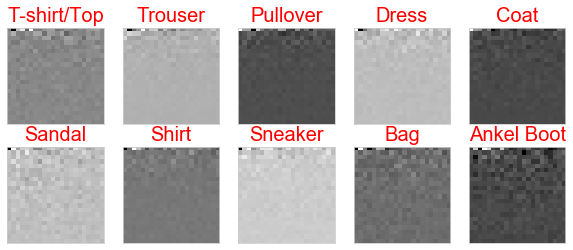

In [24]:
plot_images(create_frame_to_visualize(create_new_data_by_pca(data,484)),22,22)

*In this notebook we wanna handle with 3 pre-processing-data kind.*
- **Origin data**
- **Feature selection data** (called *data_fs* in the following)
- **PCA - using data** (called *data_pca* below)

*So now we fly to prepare data !*

# 3) Prepare data

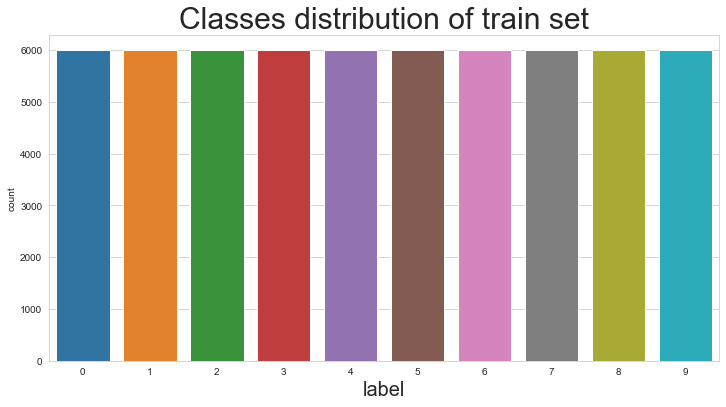

In [30]:
plt.figure(figsize=(12,6))
plt.title('Classes distribution of train set',fontsize = 30)
plt.xlabel('Classes',fontsize=20)
plt.ylabel('Number of data points')
sns.countplot(x='label',data=train_set)

*10 classes have the same number of data points.Let's say 6000. This means here is not imbalancing problem !*

## 3a) Prepare data by using PCA

In [36]:
data_pca = create_new_data_by_pca(data,484)

## 3b) Prepare data by looking at correlation

*Actually , when looking at above images , we can realise that large black spaces are available. That means there are quite many unimportant features. In other words, not so much columns are really correlated with label column. Let's see more*

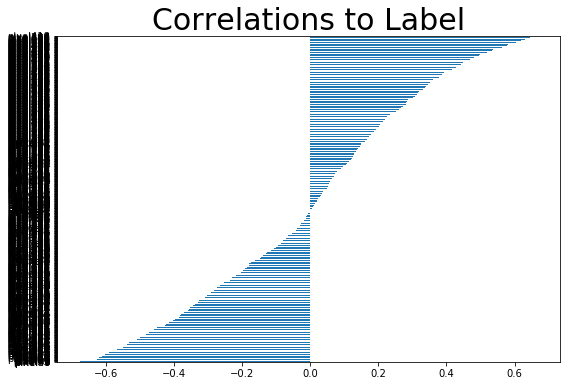

In [26]:
plt.figure(figsize=(9,6))

correlations = train_set.corr()['label'].drop('label')
correlations.sort_values().plot(kind='barh')

plt.title('Correlations to Label',fontsize=30)

plt.show()

*We choose features have absolute correlation value greater than 0.2*

In [27]:
threshold = 0.2

features = list(correlations[(abs(correlations)>threshold)].index.values)
features.append('label')

# data_fs = data[features]

*save **features** to reuse in next section*

## 3c) Train test split

*Because we handle with various data. It maybe so annoyed when train-test split implementation. Hence let's define a function to do that for us !*

In [33]:
from sklearn.model_selection import train_test_split
def split_data(data):
    
    X = data.drop('label',axis=1)
    y = data['label']

    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, stratify=y, random_state=102)

    return (X_train, X_test, y_train, y_test)

# 4)  Selecting model

*As discussed above , we gonna walk through some ensemble leanring. But before that , try some popular classifiers !*

*First of all , let's import all models we need*

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## 4a) Very popular classifiers

*For the very first , we build a set of popular classifiers*

In [ ]:
base_classifiers = [('Decision Tree', DecisionTreeClassifier()),
                    ('Naive Bayes', GaussianNB()),
                    ('Support Vector Machine', SVC()),
                    ('K-Nearest Neighbors', KNeighborsClassifier()),
                    ('Logistic Regression', LogisticRegression())]

*And now define a function to evaluate them. Remember that we are considering on sample size 5000*

In [33]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
def base_learners_evaluations(data):
    X_train, X_test, y_train, y_test = split_data(data)
    
    idx = []
    scores = {'F1 score': [], 'Recall':[]}
    for bc in base_classifiers:
        lr = bc[1]
        lr.fit(X_train, y_train)

        predictions = lr.predict(X_test)

        idx.append(bc[0])
        scores['F1 score'].append(metrics.f1_score(y_test, predictions,average='micro'))
        scores['Recall'].append(metrics.recall_score(y_test, predictions,average='micro'))
        frame_ = pd.DataFrame(data=scores, index=idx)
    return frame_.values

*To be easy to read results of models , let's define a visualise function*

In [74]:
def visualize_result_model(lyst_1,lyst_2,lyst_3,model_tuple=None,title='F1 Score') :
    fig, ax = plt.subplots(figsize=(15,7))
    x = np.arange(len(model_tuple))
    width = 0.25         # the width of the bars
    p1 = ax.bar(x - width, lyst_1 , width)
    p2 = ax.bar(x , lyst_2 , width)
    p3 = ax.bar(x + width , lyst_3 , width)

    ax.set_title(title,fontsize=25)
    ax.set_xlabel('Models',fontsize=20)
    ax.set_ylabel('score',fontsize=20)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(model_tuple)

    ax.legend((p1[0], p2[0], p3[0]), ('Origin Data', 'Filtered Data 437','PCA Data 484'))
    # ax.yaxis.set_units(inch)
    ax.autoscale_view()

    plt.show()

*Here below our very first learning !*

In [52]:
def the_very_first_learning(data,data_fs=data_fs,data_pca=data_pca) :
    f1_lyst_1 , f1_lyst_2 , f1_lyst_3 = [] , [] , []
    recall_lyst_1 , recall_lyst_2 , recall_lyst_3 = [] , [] , []
    
    data_frame_value_ = base_learners_evaluations(data)
    data_fs_frame_value_ = base_learners_evaluations(data_fs)
    data_pca_frame_value_ = base_learners_evaluations(data_pca)

    for i in range(5) :
        f1_lyst_1.append(data_frame_value_[i,0])
        f1_lyst_2.append(data_fs_frame_value_[i,0])
        f1_lyst_3.append(data_pca_frame_value_[i,0])
    
    for i in range(5) :
        recall_lyst_1.append(data_frame_value_[i,1])
        recall_lyst_2.append(data_fs_frame_value_[i,1])
        recall_lyst_3.append(data_pca_frame_value_[i,1])
    return f1_lyst_1 , f1_lyst_2 , f1_lyst_3 , recall_lyst_1 , recall_lyst_2 , recall_lyst_3

In [61]:
# frame_values = base_learners_evaluations(data)

In [53]:
# frame_values

In [64]:
# a , b , c , d , e , f = the_very_first_learning(data)

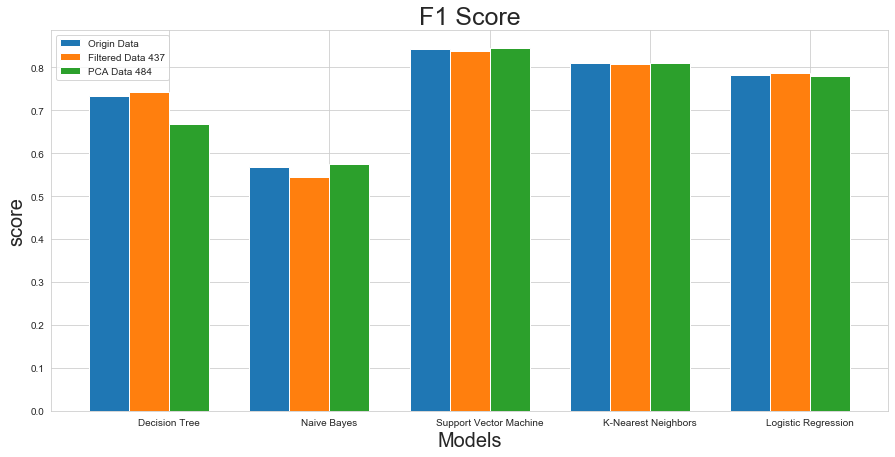

In [76]:
visualize_result_model(a,b,c,('Decision Tree','Naive Bayes','Support Vector Machine','K-Nearest Neighbors','Logistic Regression'))

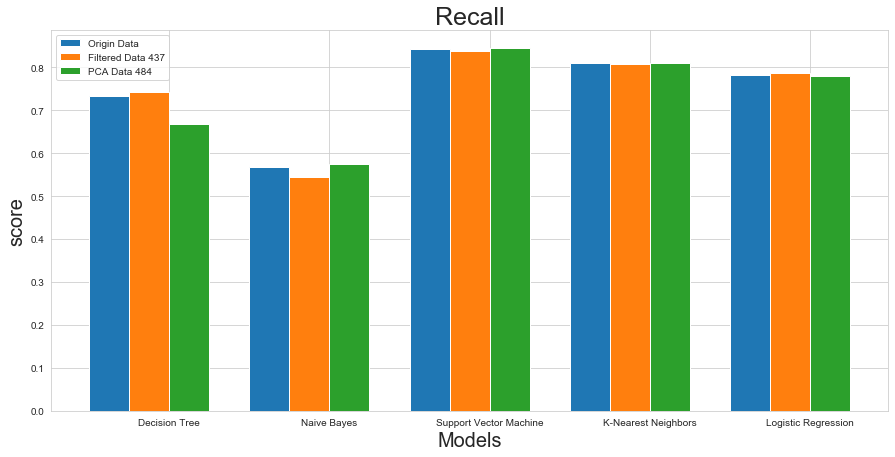

In [77]:
visualize_result_model(d,e,f,('Decision Tree','Naive Bayes','Support Vector Machine','K-Nearest Neighbors','Logistic Regression'),title='Recall')

*Now move on to some ensemble learnings !*

## 4b) Ensemble learning

In [78]:
models_comparison = {}

In [79]:
def ensemble_evaluation(data, model, label='Original'):
    X_train, X_test, y_train, y_test = split_data(data)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)       
    return pd.DataFrame({'F1 Score': [metrics.f1_score(y_test, predictions,average='micro')],
                         'Recall': [metrics.recall_score(y_test, predictions,average='micro')]}, index=[label]) 

### 4b.1) Voting

In [80]:
base_classifiers_1 = [('Decision Tree', DecisionTreeClassifier()),
                    ('Naive Bayes', GaussianNB()),
                    ('Support Vector Machine', SVC()),
                    ('K-Nearest Neighbors', KNeighborsClassifier()),
                    ('Logistic Regression', LogisticRegression())]

ensemble_1 = VotingClassifier(base_classifiers_1)    

In [88]:
def second_learning_by_voting(data,data_fs=data_fs,data_pca=data_pca) :
    ensemble_data_origin = ensemble_evaluation(data, ensemble_1, label='Original 784')
    ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble_1, label='Filtered 437')
    ensemble_data_pca = ensemble_evaluation(data_pca, ensemble_1, label='PCA 484')
    models_comparison['Voting_1'] = pd.concat([ensemble_data_origin, ensemble_data_filtered,ensemble_data_pca], axis=0)
    return models_comparison['Voting_1']

In [91]:
# second_result = second_learning_by_voting(data)

In [90]:
print('Voting evaluation')
second_result

Voting evaluation


,F1 Score,Recall
Original 784,0.843,0.843
Filtered 437,0.828,0.828
PCA 484,0.832,0.832


### 4b.2) Adding more decision trees

In [92]:
base_classifiers_2 = [('Decision Tree 3', DecisionTreeClassifier(max_depth=3)),
                    ('Decision Tree 5', DecisionTreeClassifier(max_depth=5)),
                    ('Decision Tree 8', DecisionTreeClassifier(max_depth=8)),
                    ('Naive Bayes', GaussianNB()),
                    ('Support Vector Machine', SVC()),
                    ('K-Nearest Neighbors', KNeighborsClassifier()),
                    ('Logistic Regression', LogisticRegression())]

ensemble_2 = VotingClassifier(base_classifiers_2)

In [93]:
def third_learning_by_voting_and_adding_more_decision_tree(data,data_fs=data_fs,data_pca=data_pca) :
    ensemble_data_origin = ensemble_evaluation(data, ensemble_2, label='Original 784')
    ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble_2, label='Filtered 437')
    ensemble_data_pca = ensemble_evaluation(data_pca, ensemble_2, label='PCA 484')
    models_comparison['Voting_2'] = pd.concat([ensemble_data_origin, ensemble_data_filtered,ensemble_data_pca], axis=0)
    return models_comparison['Voting_2']

In [96]:
# third_result = third_learning_by_voting_and_adding_more_decision_tree(data)

In [95]:
print('Adding more decision trees')
third_result

Adding more decision trees


,F1 Score,Recall
Original 784,0.809,0.809
Filtered 437,0.804,0.804
PCA 484,0.813,0.813


### 4b.3) Bagging

In [97]:
ensemble_3 = BaggingClassifier(n_estimators=10,
                             base_estimator=DecisionTreeClassifier(max_depth=5))

In [98]:
def fourth_learning_by_bagging(data,data_fs=data_fs,data_pca=data_pca) :
    ensemble_data_origin = ensemble_evaluation(data, ensemble_3, label='Original 784')
    ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble_3, label='Filtered 437')
    ensemble_data_pca = ensemble_evaluation(data_pca, ensemble_3, label='PCA 484')
    models_comparison['Bagging'] = pd.concat([ensemble_data_origin, ensemble_data_filtered,ensemble_data_pca], axis=0)
    return models_comparison['Bagging']

In [99]:
fourth_result = fourth_learning_by_bagging(data)

In [100]:
print('Bagging evaluation')
fourth_result

Bagging evaluation


,F1 Score,Recall
Original 784,0.741,0.741
Filtered 437,0.734,0.734
PCA 484,0.625,0.625


*Let's try to increase max_depth*

### 4b.4) Adaboost

In [101]:
ensemble_4 = AdaBoostClassifier(n_estimators=80, learning_rate=0.01)

In [102]:
def fifth_learning_by_Adaboost(data,data_fs=data_fs,data_pca=data_pca) :
    ensemble_data_origin = ensemble_evaluation(data, ensemble_4 , label='Original 784')
    ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble_4 , label='Filtered 437')
    ensemble_data_pca = ensemble_evaluation(data_pca, ensemble_4 , label='PCA 484')
    models_comparison['Adaboost'] = pd.concat([ensemble_data_origin, ensemble_data_filtered,ensemble_data_pca], axis=0)
    return models_comparison['Adaboost']

In [103]:
fifth_result = fifth_learning_by_Adaboost(data)

In [104]:
print('AdaBoost evaluation')
fifth_result

AdaBoost evaluation


,F1 Score,Recall
Original 784,0.398,0.398
Filtered 437,0.398,0.398
PCA 484,0.434,0.434


### 4b.5) Random Forest

In [105]:
ensemble_5 = RandomForestClassifier(n_estimators=50, criterion="entropy", n_jobs=4)

In [106]:
def sixth_learning_by_Random_Forest(data,data_fs=data_fs,data_pca=data_pca) :
    ensemble_data_origin = ensemble_evaluation(data, ensemble_5 , label='Original 784')
    ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble_5 , label='Filtered 437')
    ensemble_data_pca = ensemble_evaluation(data_pca, ensemble_5 , label='PCA 484')
    models_comparison['Random Forest'] = pd.concat([ensemble_data_origin, ensemble_data_filtered,ensemble_data_pca], axis=0)
    return models_comparison['Random Forest']

In [107]:
sixth_result = sixth_learning_by_Random_Forest(data)

In [108]:
print('Random forest evaluation')
sixth_result

Random forest evaluation


,F1 Score,Recall
Original 784,0.826,0.826
Filtered 437,0.828,0.828
PCA 484,0.796,0.796


### 4b.6) XGBoost

In [236]:
# !pip install xgboost

In [109]:
ensemble_6 = XGBClassifier(max_depth=5, n_jobs=4)

In [110]:
def seventh_learning_by_XGBoost(data,data_fs=data_fs,data_pca=data_pca) :
    ensemble_data_origin = ensemble_evaluation(data, ensemble_6 , label='Original 784')
    ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble_6 , label='Filtered 437')
    ensemble_data_pca = ensemble_evaluation(data_pca, ensemble_6 , label='PCA 484')
    models_comparison['XGBoost'] = pd.concat([ensemble_data_origin, ensemble_data_filtered,ensemble_data_pca], axis=0)
    return models_comparison['XGBoost']

In [111]:
seventh_result = seventh_learning_by_XGBoost(data)

In [112]:
print('XGBoost evaluation')
seventh_result

XGBoost evaluation


,F1 Score,Recall
Original 784,0.853,0.853
Filtered 437,0.847,0.847
PCA 484,0.836,0.836


*All evaluations are stored in models_comparison dictionary. We can access to get score of desired data of desired model.Below is an example*

In [116]:
models_comparison['XGBoost']['F1 Score']['Original 784']

0.853

### 4b.7) Visualize to compare models

*Nice ! Now let's visualize them to select top 2 !*

In [123]:
def plot_models_comparison(title='F1 Score'):
    labels = models_comparison.keys()
    original_data = [models_comparison[model][title]['Original 784'] for model in labels]
    filtered_data = [models_comparison[model][title]['Filtered 437'] for model in labels]
    pca_data = [models_comparison[model][title]['PCA 484'] for model in labels]

    best_score_each_model = [max(original_data[i], filtered_data[i]) for i in range(len(original_data))]
    labels = [x for _, x in sorted(zip(best_score_each_model, labels), key=lambda pair: pair[0])]
    original_data = [x for _, x in sorted(zip(best_score_each_model, original_data), key=lambda pair: pair[0])]
    filtered_data = [x for _, x in sorted(zip(best_score_each_model, filtered_data), key=lambda pair: pair[0])]
    pca_data = [x for _, x in sorted(zip(best_score_each_model, filtered_data), key=lambda pair: pair[0])]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,7))
    rects1 = ax.bar(x - width, original_data, width, label='Original Data')
    rects2 = ax.bar(x , filtered_data, width, label='Filtered Data')
    rects3 = ax.bar(x + width, pca_data, width, label='PCA Data')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores',fontsize=30)
    ax.set_xlabel('Models',fontsize=30)
    ax.set_title(title+" over sample size 5000",fontsize=35)
    ax.set_xticks(x)
    ax.set_xticklabels(labels,fontsize=20)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    
    plt.show()

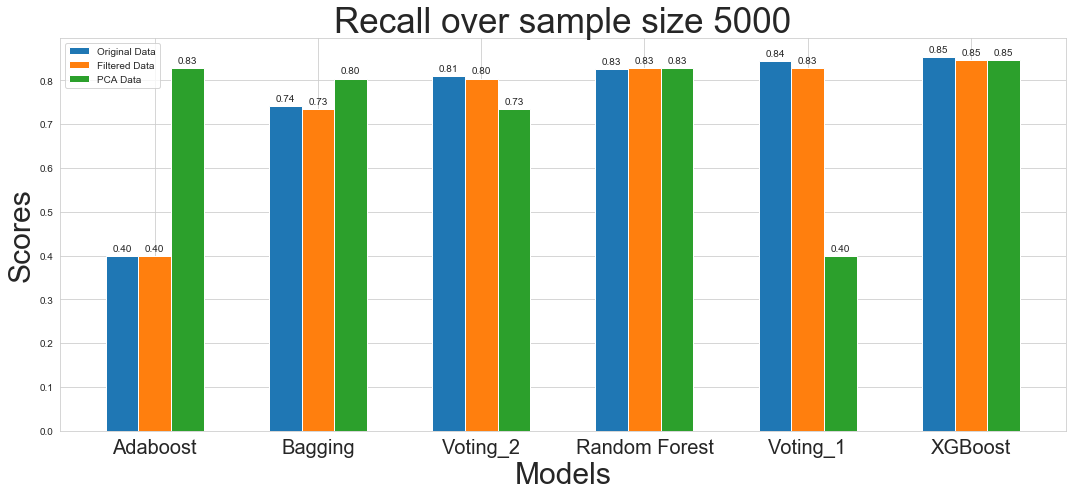

In [124]:
plot_models_comparison('Recall')

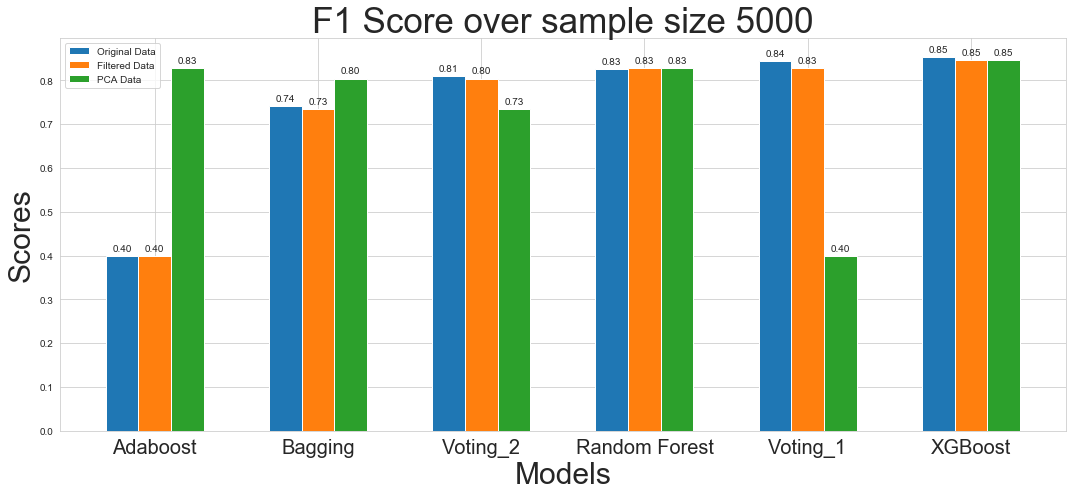

In [125]:
plot_models_comparison('F1 Score')

*Maybe Xgboots and RandomForest are the best sofar.We gonna try to optimize them. However fine-tune XGBoost took us too much time !. Hence below we just mention RandomForest fine-tune*

# 5) Optimize model

## Random Forest

### Origin data

In [265]:
# X_train, X_test, y_train, y_test = split_data(data)

In [126]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# param_distribs = {
#         'n_estimators': randint(low=1, high=300),
#         'max_depth': randint(low=1, high=30)
# }

# rfc = RandomForestClassifier()
# rnd_search = RandomizedSearchCV(rfc, param_distributions=param_distribs,
#                                 n_iter=10, cv=5, scoring='accuracy', random_state=42)
# rnd_search.fit(X_train, y_train)

In [268]:
# cvres = rnd_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(mean_score), params)

*for origin data, ideal is max_depth 19 , n_estimators 215*

### Sample retest

In [280]:
from sklearn.ensemble import RandomForestClassifier

ensemble_5 = RandomForestClassifier(max_depth=21,n_estimators=258, criterion="entropy", n_jobs=4)

In [281]:
sixth_learning_by_Random_Forest(data)

,F1 Score,Recall
Original,0.850,0.850
Filtered,0.847,0.847
PCA,0.830,0.830


# 6) Deep into dimension reduction

*Here we remind ensemble_5 and ensemble_6 for random forest and XGBoost respectively*

In [71]:
ensemble_5 = RandomForestClassifier(max_depth=21,n_estimators=258, criterion="entropy", n_jobs=4)
ensemble_6 = XGBClassifier(max_depth=5, n_jobs=-1)

In [24]:
lyst_n = [i**2 for i in range(1,29)]

In [25]:
lyst_n.sort(reverse=True)

In [26]:
a,b,c,d = [] , [] , [] , [] ### f1_score_xgbc,f1_score_rfc,recall_xgbc,recall_rfc

In [31]:
def deeply_reduce_dimension(lyst,data) :
    for i in lyst_n :
        data_pca = create_new_data_by_pca(data,i)
        xgbc = ensemble_evaluation(data_pca, ensemble_6 , label='XGBoost')
        rfc = ensemble_evaluation(data_pca, ensemble_5 , label='Random Forest')
        a.append(xgbc.values[0,0])
        b.append(rfc.values[0,0])
        c.append(xgbc.values[0,1])
        d.append(rfc.values[0,1])
    return (a,b,c,d)

In [48]:
f1_score_xgbc,f1_score_rfc,recall_xgbc,recall_rfc = deeply_reduce_dimension(lyst_n,data)

In [34]:
# import pickle

# with open('f1_score_xgbc', 'wb') as a_:
#     pickle.dump(f1_score_xgbc, a_)

In [35]:
# with open('f1_score_rfc', 'wb') as b_:
#     pickle.dump(f1_score_rfc, b_)

In [36]:
# with open('recall_xgbc', 'wb') as c_:
#     pickle.dump(recall_xgbc, c_)

In [37]:
# with open('recall_rfc', 'wb') as d_:
#     pickle.dump(recall_rfc, d_)

In [38]:
x = np.arange(28)

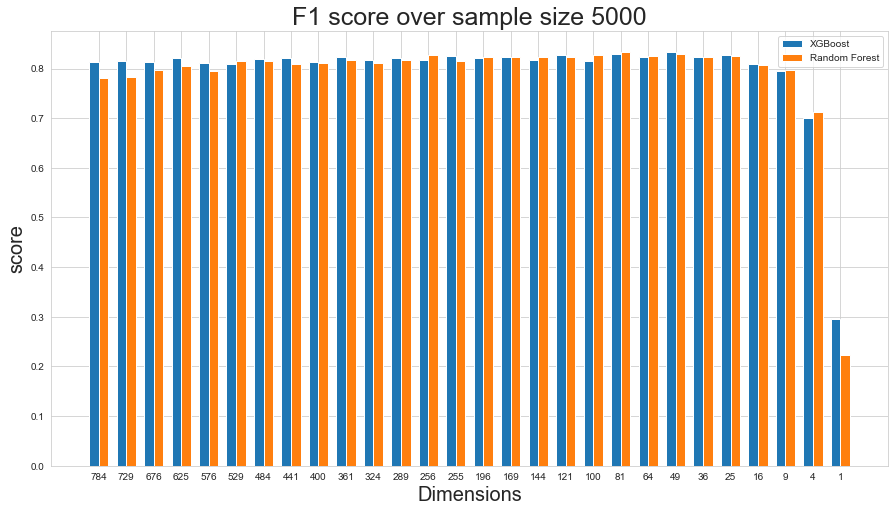

In [47]:
fig, ax = plt.subplots(figsize=(15,8))

width = 0.35         # the width of the bars
p1 = ax.bar(x, f1_score_xgbc, width)
p2 = ax.bar(x + width , f1_score_rfc, width)

ax.set_title('F1 score over sample size 5000',fontsize=25)
ax.set_xlabel('Dimensions',fontsize=20)
ax.set_ylabel('score',fontsize=20)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(('784', '729', '676', '625', '576', '529', '484', '441', '400',
                   '361', '324', '289', '256', '255', '196', '169', '144', '121',
                   '100', '81', '64', '49', '36', '25', '16', '9', '4', '1'))

ax.legend((p1[0], p2[0]), ('XGBoost', 'Random Forest'))
# ax.yaxis.set_units(inch)
ax.autoscale_view()

plt.show()

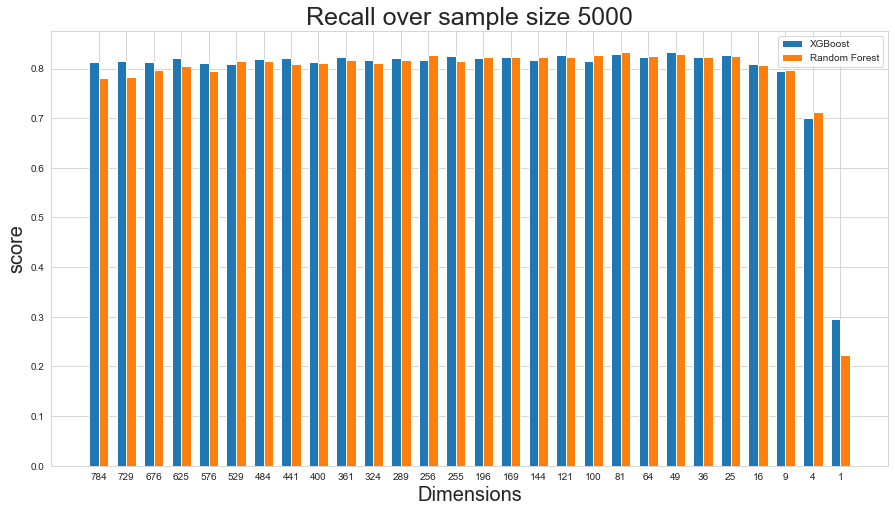

In [46]:
fig, ax = plt.subplots(figsize=(15,8))

width = 0.35         # the width of the bars
p1 = ax.bar(x, recall_xgbc, width)
p2 = ax.bar(x + width , recall_rfc, width)

ax.set_title('Recall over sample size 5000',fontsize=25)
ax.set_xlabel('Dimensions',fontsize=20)
ax.set_ylabel('score',fontsize=20)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(('784', '729', '676', '625', '576', '529', '484', '441', '400',
                   '361', '324', '289', '256', '255', '196', '169', '144', '121',
                   '100', '81', '64', '49', '36', '25', '16', '9', '4', '1'))

ax.legend((p1[0], p2[0]), ('XGBoost', 'Random Forest'))
# ax.yaxis.set_units(inch)
ax.autoscale_view()

plt.show()

*Dimension reduce so much down to 16 but F1 score and Recall still larger than 80% !!*

# 7) Train on whole train data set

In [55]:
from sklearn.model_selection import cross_val_score

*Now we move to train on whole train set with two models*
- **Random forest** : *max_depth=21,n_estimators=258, criterion="entropy", n_jobs=4*
- **XGBoost** : *max_depth=5, n_jobs=-1*

*And implement on 3 kindS of data set*
- **Origin data set 784**
- **Feature selection data 437**
- **PCA data dimension 500**

## 7a) Reading test set

In [28]:
test_set = pd.read_csv('fashion-mnist_test.csv')

In [61]:
test_set.shape

(10000, 785)

## 7b) Construct train and test function

In [82]:
a = RandomForestClassifier(max_depth=21,n_estimators=258, criterion="entropy", n_jobs=4)
b = XGBClassifier(max_depth=5, n_jobs=-1)

In [83]:
def train_rfc_xgbc(data,a,b) :
    X_train = data.drop('label',axis=1)
    y_train = data['label']
    a.fit(X_train,y_train)
    b.fit(X_train,y_train)
    return a,b

In [31]:
def test_rfc_xgbc(data,a,b) :
    X_test = data.drop('label',axis = 1)
    y_test = data['label']
    
    predictions_1 = a.predict(X_test)
    predictions_2 = b.predict(X_test)
    
    rfc_result = pd.DataFrame({'F1 Score': [metrics.f1_score(y_test, predictions_1,average='micro')],
                         'Recall': [metrics.recall_score(y_test, predictions_1,average='micro')]}, index=['Random Forest'])
    
    xgbc_result = pd.DataFrame({'F1 Score': [metrics.f1_score(y_test, predictions_2,average='micro')],
                         'Recall': [metrics.recall_score(y_test, predictions_2,average='micro')]}, index=['XGBoost'])
    
    return pd.concat([rfc_result, xgbc_result], axis=0)

In [150]:
def visualize_confusion_matrix(data,model) :
    X_test = data.drop('label',axis = 1)
    y_test = data['label']
    
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(9,6))
    plt.title(f'Confusion matrix',fontsize=30)
    sns.heatmap(cm,cmap="YlGnBu", annot=True, fmt="d")
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() 

## 7c) Training on Origin Data

In [99]:
rfc_origin , xgbc_origin = train_rfc_xgbc(train_set,a,b)

In [132]:
# import joblib

# joblib.dump(rfc_origin, "rfc_origin.pkl")
# joblib.dump(xgbc_origin, "xgbc_origin.pkl")

In [129]:
rfc_origin = joblib.load("rfc_origin.pkl")
xgbc_origin = joblib.load("xgbc_origin.pkl")

In [135]:
result_origin = test_rfc_xgbc(test_set,rfc_origin , xgbc_origin)

In [136]:
result_origin

,F1 Score,Recall
Random Forest,0.8874,0.8874
XGBoost,0.8921,0.8921


Random forest on origin set


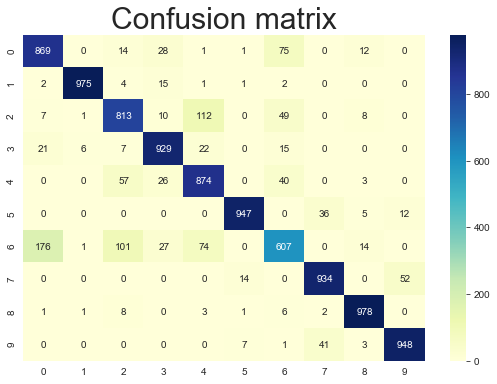

In [152]:
print('Random forest on origin set')
visualize_confusion_matrix(test_set,rfc_origin)

## Working on Filtered Data

In [29]:
filtered_train_set = train_set[features]
filtered_test_set = test_set[features]

In [ ]:
# rfc_filtered , xgbc_filtered = train_rfc_xgbc(filtered_train_set,a,b)

In [14]:
import joblib
rfc_filtered = joblib.load("rfc_filtered.pkl")
xgbc_filtered = joblib.load("xgbc_filtered.pkl")

In [34]:
result_filtered = test_rfc_xgbc(filtered_test_set,rfc_filtered , xgbc_filtered)

In [35]:
result_filtered

,F1 Score,Recall
Random Forest,0.8811,0.8811
XGBoost,0.8833,0.8833


## Working on reduced - dimension data (n_component = 500)

In [183]:
reduced_dimension_train_set = create_new_data_by_pca(train_set,500)

In [184]:
reduced_dimension_test_set = create_new_data_by_pca(test_set,500)

In [185]:
rfc_reduced_dimension = joblib.load("rfc_reduced_dimension.pkl")
xgbc_reduced_dimension = joblib.load("xgbc_reduced_dimension.pkl")

In [186]:
result_reduced_dimension = test_rfc_xgbc(reduced_dimension_test_set,rfc_reduced_dimension , xgbc_reduced_dimension)

In [187]:
result_reduced_dimension

,F1 Score,Recall
Random Forest,0.6293,0.6293
XGBoost,0.5657,0.5657


# 8) Conclusion

- **Random forest and XGboost give a highest accuracy compare to others mentioned in this notebook. Currently , Neural networks models give an accuracy up 97%. This number is actually defeatable !**

- **Among three kinds of data set , origin data stand on the 1st place , followed by feature selection data and PCA data. This is not weird because origin data have the most infomation**

- **Actually , the accuracy score gap between origin data and feature selection data is really small. Even training speed of feature selection data is so much faster then original one !**

- **About PCA data , accuracy score is quite low (just around 60% for 500 dimensions). This can be seen from the very first ! We try visualizing images and they are not themselfve anymore !!**